# Emotions 데이터 분류 실험


In [1]:
## cuda gpu 설정 코드
import os
os.add_dll_directory('C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.2\\bin')
os.environ["CUDA_VISIBLE_DEVICES"]="0"
## cuda=11.2 cudnn=8.1.0 python=3.8 tensorflow-gpu=2.10.0
## !!!!! 오류 발생 시, 위 코드 삭제 후 실행 !!!!! ##

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 데이터 읽기

In [2]:
train_data = pd.read_csv("data/train3.csv")
test_data = pd.read_csv("data/val3.csv")

docs_train = train_data["text"].values   # numpy 배열
docs_test = test_data["text"].values

y_train = train_data["emotion"]
y_train = pd.get_dummies(y_train, dtype=int)  # one-hot 인코딩
y_train = y_train.values

y_test = test_data["emotion"]
y_test = pd.get_dummies(y_test, dtype=int)
y_test = y_test.values

print(y_train.shape)
print(y_train)


(16000, 6)
[[0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [1 0 0 0 0 0]
 ...
 [0 0 1 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 1 0]]


## 텍스트 처리

### Token

In [3]:
# 토큰화 : 전체 텍스트를 대상으로 함
docs_total = np.concatenate((docs_train, docs_test))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(docs_total)
print(tokenizer.word_index)

X_train = tokenizer.texts_to_sequences(docs_train)
X_test = tokenizer.texts_to_sequences(docs_test)
print(X_train[:-5])

{'i': 1, 'feel': 2, 'and': 3, 'to': 4, 'the': 5, 'a': 6, 'feeling': 7, 'that': 8, 'of': 9, 'my': 10, 'in': 11, 'it': 12, 'like': 13, 'so': 14, 'im': 15, 'for': 16, 'me': 17, 'was': 18, 'but': 19, 'have': 20, 'is': 21, 'am': 22, 'this': 23, 'with': 24, 'not': 25, 'about': 26, 'be': 27, 'as': 28, 'on': 29, 'you': 30, 'just': 31, 'when': 32, 'at': 33, 'or': 34, 'all': 35, 'because': 36, 'more': 37, 'do': 38, 'can': 39, 'really': 40, 'up': 41, 't': 42, 'are': 43, 'by': 44, 'very': 45, 'know': 46, 'been': 47, 'if': 48, 'out': 49, 'myself': 50, 'time': 51, 'what': 52, 'how': 53, 'little': 54, 'get': 55, 'had': 56, 'will': 57, 'now': 58, 'from': 59, 'being': 60, 'they': 61, 'he': 62, 'people': 63, 'want': 64, 'would': 65, 'them': 66, 'her': 67, 'some': 68, 'still': 69, 'think': 70, 'him': 71, 'one': 72, 'ive': 73, 'an': 74, 'even': 75, 'who': 76, 'life': 77, 'there': 78, 'its': 79, 'make': 80, 'bit': 81, 'something': 82, 'we': 83, 'much': 84, 'love': 85, 'things': 86, 'going': 87, 's': 88, 'd

### padding

In [4]:
max_sentence_len = max(map(len, (X_train + X_test)))
print("한 문장이 가지는 최대 단어 개수: " + str(max_sentence_len))

x_train = pad_sequences(X_train, max_sentence_len)
x_test = pad_sequences(X_test, max_sentence_len)

한 문장이 가지는 최대 단어 개수: 66


### word size

In [5]:
word_size = len(tokenizer.word_index) + 1
print(word_size)

16197


## 모델1 설정
Flatten layer와 Dense layer

In [6]:
inputs = keras.Input(shape=(max_sentence_len,))
x = layers.Embedding(word_size, 60, input_length=max_sentence_len)(inputs)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(6, activation='softmax')(x) #softmax는 0~1
model1 = keras.Model(inputs=inputs, outputs=outputs)

In [7]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 66)]              0         
                                                                 
 embedding (Embedding)       (None, 66, 60)            971820    
                                                                 
 flatten (Flatten)           (None, 3960)              0         
                                                                 
 dense (Dense)               (None, 128)               507008    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 6)                 390   

### 모델1 학습

In [8]:
checkpoint = keras.callbacks.ModelCheckpoint(filepath='model/nlq_hw01_01.hdf5', monitor='loss', save_best_only=True, verbose=0)

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history1 = model1.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, batch_size=30, callbacks=[checkpoint])

Epoch 1/30
534/534 [==============================] - 4s 5ms/step - loss: 1.3741 - accuracy: 0.4526 - val_loss: 0.7464 - val_accuracy: 0.7485
Epoch 2/30
534/534 [==============================] - 2s 4ms/step - loss: 0.4208 - accuracy: 0.8592 - val_loss: 0.4565 - val_accuracy: 0.8565
Epoch 3/30
534/534 [==============================] - 3s 5ms/step - loss: 0.1109 - accuracy: 0.9658 - val_loss: 0.4878 - val_accuracy: 0.8630
Epoch 4/30
534/534 [==============================] - 3s 5ms/step - loss: 0.0503 - accuracy: 0.9856 - val_loss: 0.5919 - val_accuracy: 0.8495
Epoch 5/30
534/534 [==============================] - 3s 5ms/step - loss: 0.0310 - accuracy: 0.9923 - val_loss: 0.6413 - val_accuracy: 0.8520
Epoch 6/30
534/534 [==============================] - 2s 5ms/step - loss: 0.0255 - accuracy: 0.9937 - val_loss: 0.6606 - val_accuracy: 0.8610
Epoch 7/30
534/534 [==============================] - 2s 4ms/step - loss: 0.0200 - accuracy: 0.9947 - val_loss: 0.6722 - val_accuracy: 0.8600
Epoch 

In [9]:
print(min(history1.history["loss"]))
print(max(history1.history["accuracy"]))
print(min(history1.history["val_loss"]))
print(max(history1.history["val_accuracy"]))

0.008065235801041126
0.996749997138977
0.45651277899742126
0.8629999756813049


In [10]:
df_result1 = pd.DataFrame(history1.history)
print(df_result1.head())

       loss  accuracy  val_loss  val_accuracy
0  1.374052  0.452563  0.746407        0.7485
1  0.420765  0.859187  0.456513        0.8565
2  0.110874  0.965813  0.487781        0.8630
3  0.050312  0.985563  0.591864        0.8495
4  0.031019  0.992312  0.641347        0.8520


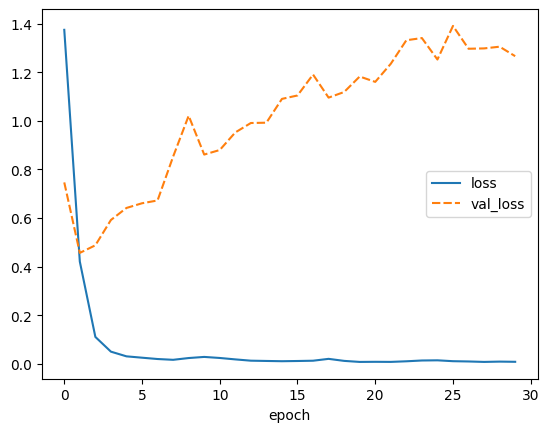

In [11]:
sns.lineplot(df_result1[["loss", "val_loss"]])
plt.xlabel("epoch")
plt.show()

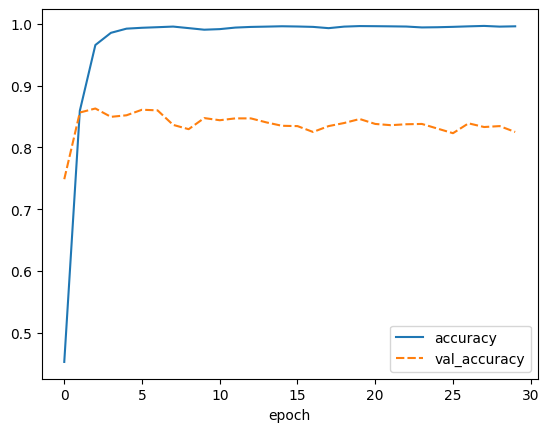

In [12]:
sns.lineplot(df_result1[["accuracy", "val_accuracy"]])
plt.xlabel("epoch")
plt.show()

## 모델2 설정
LSTM layer와 Dense layer

In [21]:
inputs = keras.Input(shape=(max_sentence_len,))
x = layers.Embedding(word_size, 60, input_length=max_sentence_len)(inputs)
x = layers.LSTM(128)(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(6, activation='softmax')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)

In [22]:
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 66)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 66, 60)            971820    
                                                                 
 lstm_1 (LSTM)               (None, 128)               96768     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 6)                 390 

### 모델2 학습

In [23]:
checkpoint = keras.callbacks.ModelCheckpoint(filepath='model/nlq_hw01_02.hdf5', monitor='loss', save_best_only=True, verbose=0)

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, batch_size=30, callbacks=[checkpoint])

Epoch 1/30
534/534 [==============================] - 8s 13ms/step - loss: 1.2494 - accuracy: 0.5014 - val_loss: 0.6577 - val_accuracy: 0.7625
Epoch 2/30
534/534 [==============================] - 6s 11ms/step - loss: 0.4504 - accuracy: 0.8361 - val_loss: 0.3102 - val_accuracy: 0.9045
Epoch 3/30
534/534 [==============================] - 6s 12ms/step - loss: 0.1833 - accuracy: 0.9433 - val_loss: 0.2407 - val_accuracy: 0.9215
Epoch 4/30
534/534 [==============================] - 6s 12ms/step - loss: 0.1191 - accuracy: 0.9596 - val_loss: 0.2647 - val_accuracy: 0.9100
Epoch 5/30
534/534 [==============================] - 6s 11ms/step - loss: 0.0813 - accuracy: 0.9725 - val_loss: 0.3603 - val_accuracy: 0.9105
Epoch 6/30
534/534 [==============================] - 6s 12ms/step - loss: 0.0665 - accuracy: 0.9766 - val_loss: 0.3232 - val_accuracy: 0.9175
Epoch 7/30
534/534 [==============================] - 6s 12ms/step - loss: 0.0519 - accuracy: 0.9822 - val_loss: 0.3349 - val_accuracy: 0.9210

In [24]:
print(min(history2.history["loss"]))
print(max(history2.history["accuracy"]))
print(min(history2.history["val_loss"]))
print(max(history2.history["val_accuracy"]))

0.008078924380242825
0.9961875081062317
0.24067991971969604
0.9294999837875366


In [25]:
df_result2 = pd.DataFrame(history2.history)
print(df_result2.head())

       loss  accuracy  val_loss  val_accuracy
0  1.249390  0.501437  0.657719        0.7625
1  0.450417  0.836125  0.310153        0.9045
2  0.183287  0.943313  0.240680        0.9215
3  0.119060  0.959625  0.264729        0.9100
4  0.081294  0.972500  0.360307        0.9105


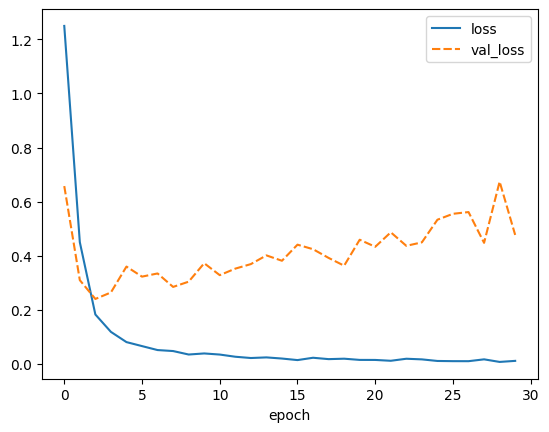

In [26]:
sns.lineplot(df_result2[["loss", "val_loss"]])
plt.xlabel("epoch")
plt.show()

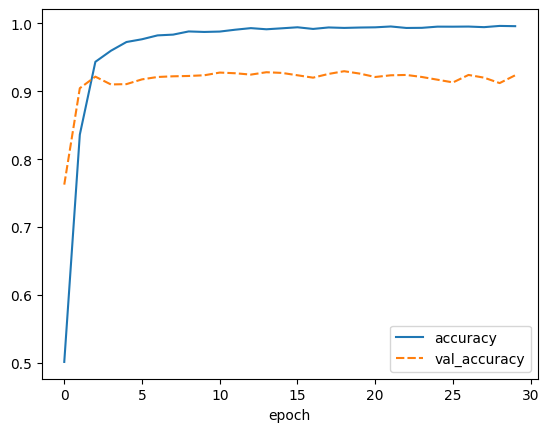

In [27]:
sns.lineplot(df_result2[["accuracy", "val_accuracy"]])
plt.xlabel("epoch")
plt.show()